# Bar data

In [16]:
from ib_insync import *
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=14)

<IB connected to 127.0.0.1:7497 clientId=14>

## Historical data

To get the earliest date of available bar data the "head timestamp" can be requested:

In [21]:
contract = Contract()
contract.symbol = "MES"
contract.secType = "FUT"
contract.exchange = "GLOBEX"
contract.currency = "USD"
contract.lastTradeDateOrContractMonth = "202212"
ib.qualifyContracts(contract)

[Contract(secType='FUT', conId=515416607, symbol='MES', lastTradeDateOrContractMonth='20221216', multiplier='5', exchange='GLOBEX', currency='USD', localSymbol='MESZ2', tradingClass='MES')]

In [22]:
ib.reqHeadTimeStamp(contract, whatToShow='MIDPOINT', useRTH=True)

datetime.datetime(2021, 9, 22, 22, 0)

To request hourly data of the last 60 trading days:

In [23]:
# request delayed data
ib.reqMarketDataType(3)

In [24]:

bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='90 D',
        barSizeSetting='1 day',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)

bars[0]

BarData(date=datetime.date(2022, 3, 10), open=4254.0, high=4254.0, low=4254.0, close=4254.0, volume=0.0, average=4254.0, barCount=0)

Convert the list of bars to a data frame and print the first and last rows:

In [25]:
df = util.df(bars)

display(df.head())
display(df.tail())

,date,open,high,low,close,volume,average,barCount
0,2022-03-10,4254.0,4254.00,4254.00,4254.00,0.0,4254.0000,0
1,2022-03-11,4227.5,4227.50,4199.75,4199.75,2.0,4216.2500,2
2,2022-03-14,4200.0,4200.00,4170.25,4170.25,6.0,4200.0000,2
3,2022-03-15,4243.0,4259.25,4243.00,4259.00,3.0,4252.4125,3
4,2022-03-16,4295.0,4370.00,4295.00,4357.50,6.0,4329.0000,6


,date,open,high,low,close,volume,average,barCount
85,2022-07-13,3780.75,3850.50,3780.00,3812.75,822.0,3817.5500,425
86,2022-07-14,3771.50,3817.00,3741.25,3814.00,856.0,3778.4375,510
87,2022-07-15,3859.25,3884.75,3837.00,3880.50,629.0,3867.1250,374
88,2022-07-18,3913.75,3922.00,3838.00,3856.25,697.0,3887.8000,413
89,2022-07-19,3892.50,3914.00,3884.50,3912.75,290.0,3899.0500,146


Instruct the notebook to draw plot graphics inline:

In [26]:
%matplotlib inline

Plot the close data

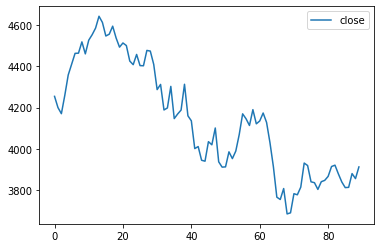

In [27]:
df.plot(y='close');

There is also a utility function to plot bars as a candlestick plot. It can accept either a DataFrame or a list of bars. Here it will print the last 100 bars:

In [ ]:
util.barplot(bars[-100:], title=contract.symbol);

## Historical data with realtime updates

A new feature of the API is to get live updates for historical bars. This is done by setting `endDateTime` to an empty string and the `keepUpToDate` parameter to `True`.

Let's get some bars with an keepUpToDate subscription:

In [ ]:
#contract = Forex('EURUSD')

bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='900 S',
        barSizeSetting='10 secs',
        whatToShow='MIDPOINT',
        useRTH=True,
        formatDate=1,
        keepUpToDate=True)

Replot for every change of the last bar:

In [ ]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def onBarUpdate(bars, hasNewBar):
    plt.close()
    plot = util.barplot(bars)
    clear_output(wait=True)
    display(plot)

bars.updateEvent += onBarUpdate

ib.sleep(10)
ib.cancelHistoricalData(bars)

Realtime bars
------------------

With ``reqRealTimeBars`` a subscription is started that sends a new bar every 5 seconds.

First we'll set up a event handler for bar updates:

In [ ]:
def onBarUpdate(bars, hasNewBar):
    print(bars[-1])

Then do the real request and connect the event handler,

In [ ]:
bars = ib.reqRealTimeBars(contract, 5, 'MIDPOINT', False)
bars.updateEvent += onBarUpdate

let it run for half a minute and then cancel the realtime bars.

In [ ]:
ib.sleep(30)
ib.cancelRealTimeBars(bars)

The advantage of reqRealTimeBars is that it behaves more robust when the connection to the IB server farms is interrupted. After the connection is restored, the bars from during the network outage will be backfilled and the live bars will resume.

reqHistoricalData + keepUpToDate will, at the moment of writing, leave the whole API inoperable after a network interruption.

In [28]:
ib.disconnect()